# Project
## Analyzing the effect of SFI on the likelihood of contacts occurring on various HF amateur bands
#### By yarov3so (VA2ZLT)

#### Context
In this project, I will be studying the effect of solar flux index (SFI) on the likelihood of a contact occuring on HF amateur bands between two locations (a source and a destination). SFI is a measurement of the amount of radio emissions at a wavelength of 10.7 cm (2.8 GHz) from the Sun, and it changes constantly based on solar activity. It is common knowledge in the HAM radio community that space weather has a profound effect on radio communication on HF bands, as solar radiation ionizes the ionosphere, which enables it to reflect/refract the radiowaves in the HF part of the spectrum back towards the ground instead of allowing them to escape into space. This phenomenon, commonly referred to as "skip", allows amateur radio enthusiasts to communicate beyond line of sight and even over great distances (DX), depending on the number of bounces the radiowave experiences. Radio amateurs often talk about "shooting skip", though this phenomenon isn't exclusive to the ham radio community. In fact, as any seasoned (and quite likely disillusioned) CB radio user can readily confirm, skip occurs on the CB band (11m) as well, which makes certain channels unusable at times due to the receiver inadvertently picking up transmissions from several hundreds of kilometers away... When two radio amateurs make contact over radio, they refer to it as a QSO - an abbreviation that will be used frequently in this project. Below is radiowave propagation diagram illustrating the skip phenomenon:

<img src="skip_diagram.png" alt="Skip diagram">

#### Motivation

You might be wondering - why bother with this study? Well, while world maps showing favourable DX propagation conditions do exist (https://hf.dxview.org comes to mind), they all seem to rely (almost) exclusively on geomagnetic and solar activity data. One of the tools I will build in this project will use historical information about the number of QSOs occurring between two regions for a given SFI range to recommend the regions with which a QSO is most likely. This information is valuable to radio amateurs with directional antennas (like a Yagi antenna), as they need to adjust their antenna's orientation based on the country/location they are aiming to contact. The other tool will use the same historical information to recommend the band on which a QSO is most likely to occur. Wealthy amateurs with HF rigs capable of operating on several bands could benefit from this information to prioritize the most opportune bands when calling CQDX (ham lingo for attempting to make contact with a distant station). *Note to self: I aspire to be one of these wealthy amateurs someday...* 

No space weather maps were tortured in the making of these tools!

Pragmatism aside, the first half of this project deals with the more abstract question alluded to in the very beginning: how exactly does SFI affect the likelihood of a QSO occuring on HF bands? Answering this question will require using various data analysis techniques, mainly plotting, regression and scripting. In addition, I will define a useful measure referred to as "QSO count significance", which will be useful for studying the effects of SFI on QSO counts across bands and countries. This project also requires heaps and heaps of QSO data, which I will eagerly scrape from https://clublog.org/propagation.php. Besides, it's *not* a bad idea to showcase my proficiency with scraping techniques. The scraped data will be conveniently given the structure of a JSON tree for use throughout the project. 

*Quick note: scraping all the necessary data takes a very long time, so I will only consider contacts originating in Canada. However, my scraping script can easily handle any of the source countries listed in the dropdown menu on clublog.org.*

Without further ado, let the fun begin...

### Part 1: Scraping the QSO data

In [25]:
# imports

from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as bs
import os
import json
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns 
import requests
import time

sns.set()

In [163]:
def scraping_initializer(): # this function loads the Chrome webdriver and logs into clublog.org

    global driver

    driver = webdriver.Chrome()
    driver.get('https://clublog.org/loginform.php')
    
    username_input = WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.NAME, 'fEmail')))
    password_input = WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.NAME, 'fPassword')))
    login_button = WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="submit"]'))) 
    
    username_input.send_keys('yaroveso@gmail.com')
    password_input.send_keys('bootcamp') # for the sake of simplicity
    login_button.click()
    
    driver.get('https://clublog.org/propagation.php')

scraping_initializer()

In [215]:
# Listing all the possible options for source/destinations
source = Select(driver.find_element(By.ID, 'formsource'))
source_options=[x.text for x in source.options[1:]]
source_options # This is a list of all the available source/destination countries.

['AFGHANISTAN',
 'AGALEGA & ST BRANDON ISLANDS',
 'ALAND ISLANDS',
 'ALASKA',
 'ALBANIA',
 'ALGERIA',
 'AMERICAN SAMOA',
 'AMSTERDAM & ST PAUL ISLANDS',
 'ANDAMAN & NICOBAR ISLANDS',
 'ANDORRA',
 'ANGOLA',
 'ANGUILLA',
 'ANNOBON',
 'ANTARCTICA',
 'ANTIGUA & BARBUDA',
 'ARGENTINA',
 'ARMENIA',
 'ARUBA',
 'ASCENSION ISLAND',
 'ASIATIC RUSSIA',
 'AUSTRAL ISLANDS',
 'AUSTRALIA',
 'AUSTRIA',
 'AVES ISLAND',
 'AZERBAIJAN',
 'AZORES',
 'BAHAMAS',
 'BAHRAIN',
 'BAKER HOWLAND ISLANDS',
 'BALEARIC ISLANDS',
 'BANABA ISLAND',
 'BANGLADESH',
 'BARBADOS',
 'BELARUS',
 'BELGIUM',
 'BELIZE',
 'BENIN',
 'BERMUDA',
 'BHUTAN',
 'BOLIVIA',
 'BONAIRE',
 'BOSNIA-HERZEGOVINA',
 'BOTSWANA',
 'BOUVET ISLAND',
 'BRAZIL',
 'BRITISH VIRGIN ISLANDS',
 'BRUNEI',
 'BULGARIA',
 'BURKINA FASO',
 'BURUNDI',
 'CAMBODIA',
 'CAMEROON',
 'CANADA',
 'CANARY ISLANDS',
 'CAPE VERDE',
 'CAYMAN ISLANDS',
 'CENTRAL AFRICAN REPUBLIC',
 'CENTRAL KIRIBATI',
 'CEUTA & MELILLA',
 'CHAD',
 'CHAGOS ISLANDS',
 'CHATHAM ISLAND',
 'CHEST

In [2]:
# The scraping code is conveniently broken down into several functions

def scrape_graphs(driver): # scrapes the bar charts from a single page

    soup=bs(driver.page_source)
    qso_count={}
    propagation_charts=soup.find_all('table',class_='propagationChart2')
    
    for i in range(11):
    
        band=int(re.search(r'(\d+)m',propagation_charts[i].text).group(1))
        qso_total=int(re.search(r' (\d+) ',propagation_charts[i].text).group(1))
        qso_count[band]={}
        
        if qso_total==0:
    
            for num in range(24):
                qso_count[band][num]=0
                
            continue
        
        chart=propagation_charts[i].find_all('img',class_='real')
    
        height_total=sum([float(re.findall(r'\d+\.?\d*',x.get('height'))[0]) for x in chart])
             
        for el in chart:
            
            time=int(re.search(r'_(\d+)',el.get('id')).group(1))
            height=float(re.findall(r'\d+\.?\d*',el.get('height'))[0])
            qso_count[band][time]=round(height*qso_total/height_total) # using the pixel heights of bars in the bar chart to infer QSO counts
    
            for num in range(24):
                
                if num not in qso_count[band].keys():
                    qso_count[band][num]=0 # in the absence of a bar, infer that the QSO count is null

    return qso_count
    

def select_params(Source,Dest,Month,Min_sfi,Max_sfi): # selects parameters for the website to display the relevant bar charts 
    
    source = Select(driver.find_element(By.ID, 'formsource'))
    source.select_by_visible_text(Source)
    dest = Select(driver.find_element(By.ID, 'formdest'))
    dest.select_by_visible_text(Dest)
    month = Select(driver.find_element(By.NAME, 'month'))
    month.select_by_visible_text(Month)
    min_sfi = Select(driver.find_element(By.NAME, 'formsfi'))
    min_sfi.select_by_visible_text(str(Min_sfi))
    max_sfi = Select(driver.find_element(By.NAME, 'formusfi'))
    max_sfi.select_by_visible_text(str(Max_sfi))
    

def scrape_range(source,dest,sfi_invl_size): # Scrapes all QSO data for QSOs occuring between a given source and a given destination
                                             # SFI interval size has to be one of: [20, 25, 30, 50, 60, 100]

    qso_source_to_dest={}
    
    months=[x.text for x in Select(driver.find_element(By.NAME, 'month')).options]

    for month in months:

        print(f'    Month: {month}')
        print(f'        SFI range: 0 to {sfi_invl_size}')
        qso_source_to_dest[month]={}
        select_params(source,dest,month,'No limit',sfi_invl_size)
        run_report=WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.XPATH, '//*[@type="submit"]'))) 
        run_report.click()
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'chart_160')))
        qso_source_to_dest[month][f'(0,{sfi_invl_size})']=scrape_graphs(driver) # unfortunately, JSON doesn't support tuple indices

        l=sfi_invl_size
        h=2*sfi_invl_size
        
        while h<=300:

            print(f'        SFI range: {l} to {h}')
            select_params(source,dest,month,l,h)
            run_report=WebDriverWait(driver, 1).until(EC.element_to_be_clickable((By.XPATH, '//*[@type="submit"]'))) 
            run_report.click()
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'chart_160')))
            qso_source_to_dest[month][f'({l},{h})']=scrape_graphs(driver)
            l=h
            h+=sfi_invl_size

    return qso_source_to_dest
    

def make_json(source,dest_list,sfi_invl_size,filename='qso_data_dump.json'): # SFI interval size has to be one of: [20, 25, 30, 50, 60, 100]
                                                                             # source must be a string and dest_list must be a list. Please consult documentation for a list of available countries.
    scraping_initializer()

    print('Grab a beer! This will take a while...')
    
    mydict={}
    
    for dest in dest_list: # loops over all destinations in the list
        print(f'Pulling QSO data between {source} and {dest}...')
        mydict[dest]=scrape_range(source,dest,sfi_invl_size)

    mydict_str = json.dumps(mydict, indent=4)
    
    with open(filename, "w") as f: # dumps the scraped data into a JSON file
        
        print(f'Dumping dataset to {filename}...')
        f.write(mydict_str)

    print('Done!')

    return mydict


For this project, I chose a pool of 33 destinations, most of which appear on Wikipedia's table of countries with the most amateur radio operators: https://en.wikipedia.org/wiki/Amateur_radio_operator. Scraping QSO data for all the possible destinations in any reasonable amount of time is not feasible. 

The chosen destinations are as follows:  

In [ ]:
chosen_destinations=['CANADA','UNITED STATES OF AMERICA','THAILAND','CHINA','FEDERAL REPUBLIC OF GERMANY','SPAIN','EUROPEAN RUSSIA','ASIATIC RUSSIA','JAPAN','DEM. REP. OF THE CONGO','ETHIOPIA','ENGLAND','BRAZIL','TURKEY','HAWAII','SVALBARD','SWEDEN','REPUBLIC OF SOUTH AFRICA','INDIA','AUSTRALIA','INDONESIA','ARGENTINA','POLAND','ANTARCTICA','NEW ZEALAND','ZIMBABWE','MADAGASCAR','UNITED ARAB EMIRATES','COLOMBIA','GREENLAND','TANZANIA','VIET NAM','PHILIPPINES','MEXICO']
chosen_destinations # Notice that Canada itself (the source) appears on the list. This is not a fluke - I definitely want to consider QSOs occuring within Canada as well!


Now, I will scrape the data needed for the project in four steps and merge the resulting JSONs together. I select 20 as the length of each SFI range for this project.

In [ ]:
# Step 1
qso=make_json('CANADA',chosen_destinations[:8],20,'qso_data_dump_1-8.json') 

In [ ]:
# Step 2
qso=make_json('CANADA',chosen_destinations[8:16],20,'qso_data_dump_9-16.json') 

In [ ]:
# Step 3
qso=make_json('CANADA',chosen_destinations[16:27],20,'qso_data_dump_17-27.json')

In [ ]:
# Step 4
qso=make_json('CANADA',chosen_destinations[27:33],20,'qso_data_dump_28-33.json') 

In [170]:
# Merging the JSONs

with open("qso_data_dump_1-8.json", "r") as f:
    json_data_1 = json.load(f)
with open("qso_data_dump_9-16.json", "r") as f:
    json_data_2 = json.load(f)
with open("qso_data_dump_17-27.json", "r") as f:
    json_data_3 = json.load(f)
with open("qso_data_dump_28-33.json", "r") as f:
    json_data_4 = json.load(f)

merged_dict = {**json_data_1, **json_data_2, **json_data_3, **json_data_4}
qso_dataset_str=json.dumps(merged_dict, indent=4)

with open('qso_data_dump.json', "w") as f:
    f.write(qso_dataset_str)

#### QSO Dataset structure:

##### Destination (string) --> Month (string, with 'All' for all months) --> SFI range (string) --> HF Band (string) --> Hour (string, 0 to 23)

##### Output (leaf nodes): Number of QSOs (integer)

### Part 2: Defining some useful functions

In [5]:
def import_dataset(path_to_dataset='qso_data_dump.json'): # loads the qso dataset to be used for analysis and recommendation engines 
    
    global qso_dataset
    
    with open(path_to_dataset, "r") as f:
        qso_dataset = json.load(f)
        
    print('QSO dataset loaded successfully.')
    
    return qso_dataset # MUST BE USED WITH SEMICOLON to prevent python kernel from freezing/panicking due to size of the dataset!

import_dataset()

def midpoint(mystr): # used for calculating the midpoints of SFI range intervals
    
    tup=eval(mystr)
    return (tup[0]+tup[1])/2

def time_range_maker(hour,tolerance): # gives a list of all times (hours in 24-hour time) that are at most a 'tolerance' value away from a given 'hour'
    
    if hour-tolerance<0 and hour+tolerance<24:
        time_range=list(range((hour-tolerance)%24,24))+list(range(0,hour+tolerance+1))
    elif hour-tolerance>=0 and hour+tolerance>=24:
        time_range=list(range(hour-tolerance,24))+list(range(0,((hour+tolerance)%24) +1))
    elif hour-tolerance>=0 and hour+tolerance<24:
        time_range=list(range(hour-tolerance,hour+tolerance+1))
    else:
        time_range=list(range(24))

    return time_range

def depth_finder(tree): # finds the depth of any dictionary tree - not used in this project
    
    if type(tree)!=dict:
        return 0
    else:
        for key in tree:
            key_selected=key
            break
            
        return 1+depth_finder(tree[key_selected])

def tree_sum(mask,tree=qso_dataset): # uses a mask (list) to sum over the leaves of a dictionary tree 
                                     # can be generalized to other aggregation functions, but this is not necessary for this project
    if len(mask)==1:                 
        
        if len(mask[0])==0:
            return sum([tree[key] for key in tree])
        else:
            return sum([tree[key] for key in mask[0]])
            
    else:
        
        if len(mask[0])==0:
            return sum([tree_sum(mask[1:],tree[key]) for key in tree])
        else:
            return sum([tree_sum(mask[1:],tree[key]) for key in mask[0]])

def get_sfi(): # scrapes the current SFI in real time from WM7D's website - will sometimes fail when SFI info is getting updated on the website
    
    response = requests.get('https://www.wm7d.net/hamradio/solar/')
    soup=bs(response.content)
    
    return int(soup.find_all('font')[2].find('b').text)
    

QSO dataset loaded successfully.


### Part 3: Analyzing and plotting the effect of SFI on QSOs

In [410]:
# The SFI range (20,40) needs to be excluded from further analysis, since no QSOs have occured for that range regardless of destination/month/band/hour:
tree_sum([[],[],['(20,40)'],[],[]])


0

#### Introducing QSO count significance  

In order to understand how the QSO count between a source and a destination is affected by SFI, using QSO counts themselves is not the correct approach. In fact, plotting a histogram of QSO counts against SFI ranges reveals a single peak around commonly observed SFI values in just about all cases. This relationship does not capture the actual effect of SFI on QSO counts, but rather the fact that some SFI values are much more common than others. It is rare for SFI to climb all the way to 300, just as it is rare for it to drop down to near 0. The way to get around this issue is by studying the ratio of QSO counts between a source and a given destination to QSO counts between a source and all the documented destinations. This ratio is what I henceforth call "QSO count significance". 

##### QSO count significance: the ratio of QSO counts between a source and a given destination to QSO counts between a source and all the documented destinations.

QSO count significance is unaffected by varying overall QSO counts for specific SFI ranges thanks to the ratio used to define it. An analogous definition will be used when building the band recommendation engine: 

##### QSO count significance (used later): the ratio of QSO counts occuring on a given band to QSO counts occuring on all the documented bands.

In [4]:
# Loading the QSO dataset
import_dataset();

QSO dataset loaded successfully.


In [5]:
# Constructing the data for use in plots

destinations=list(qso_dataset.keys())
coefs={}
qso_count_sig={}

# Fecthing all SFI ranges and bands
first_dest=list(qso_dataset.keys())[0]
sfi_ranges=list(qso_dataset[first_dest]['All'].keys())
del sfi_ranges[1] # We exclude the range (20,40)
bands=list(qso_dataset[first_dest]['All'][sfi_ranges[0]].keys())

for k in range(len(destinations)):
    
    dest=destinations[k]
    qso_count_sig[dest]={}
    coefs[dest]={}
    
    for band in bands:
        
        # Constructing QSO count significance to be plotted for each destination and band 
        y=[]
        for sfi_range in sfi_ranges: 
            qso_count=tree_sum([[dest],['All'],[sfi_range],[band],[]]) # Number of contacts occuring on a given HF band between source and given destination for a specific SFI range 
            qso_count_all_dest = tree_sum([[],['All'],[sfi_range],[band],[]]) # Number of contacts occuring on a given HF band between source and ALL documented destinations for a specific SFI range 
            if qso_count_all_dest!=0:
                y.append(qso_count/qso_count_all_dest)
            else:
                y.append(0)  

        qso_count_sig[dest][band]=y

        # Analyzing the strength and direction of the relationship between QSO count significance and SFI
        if np.mean(y)!=0:
            y=y/np.mean(y) # rescaling y by the mean ensures that we are able to use the linear coefficient from OLS to faithfully compare the effect of SFI on QSO count significance across different bands and even different destinations
                           # heuristically, it is a way to ensure that the linear coefficients from OLS capture the actual effect of SFI on QSO count significance without being affected by the differing scales of QSO count significance vs SFI relationships
        
        model=sm.OLS(y,sm.add_constant([midpoint(x) for x in sfi_ranges])).fit()
        coefs[dest][band]=(model.params,model.bse) 
    

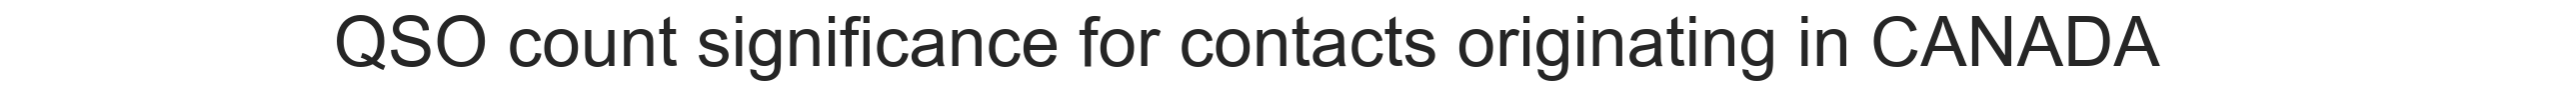

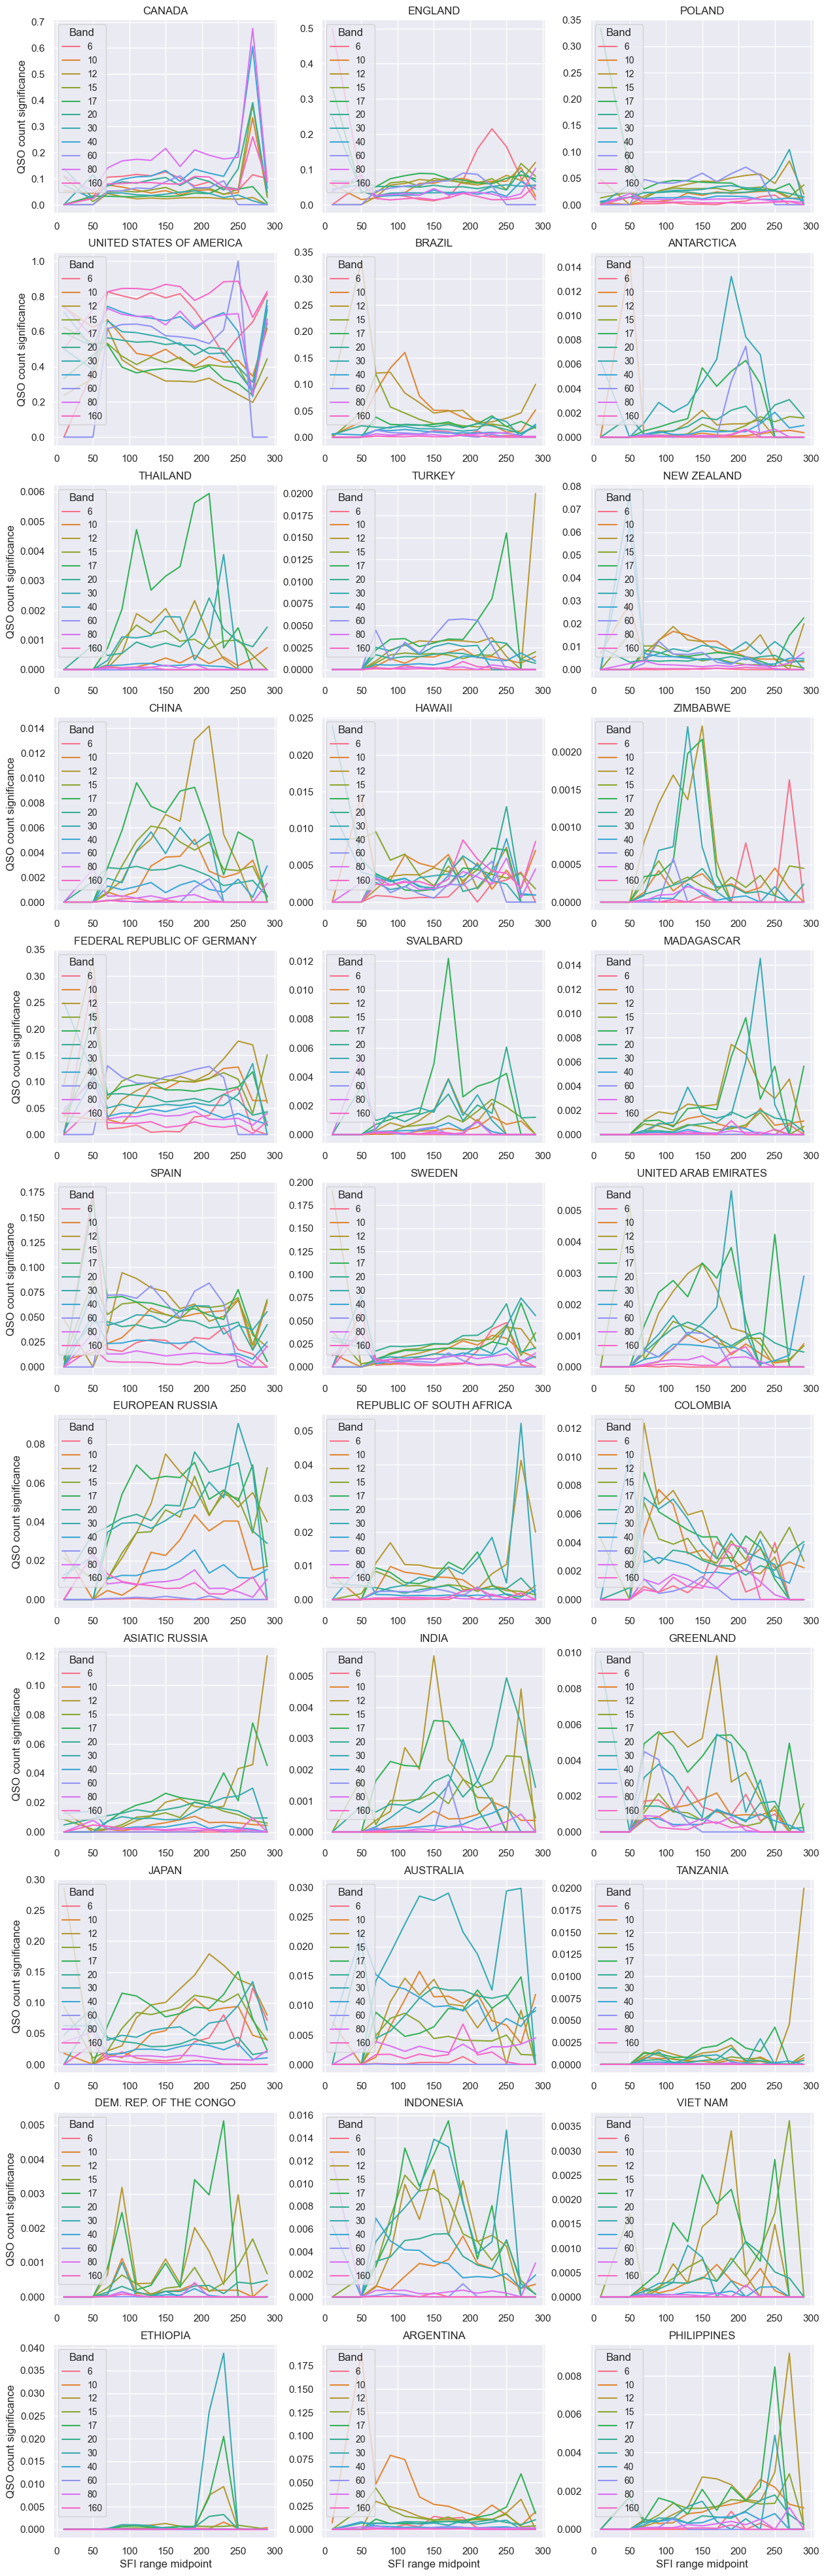

In [515]:
# Plotting the effect of SFI on QSO count significance

palette = sns.color_palette("husl", 11)
source='CANADA'

# Fecthing all SFI ranges and bands
first_dest=list(qso_dataset.keys())[0]
sfi_ranges=list(qso_dataset[first_dest]['All'].keys())
del sfi_ranges[1] # We exclude the range (20,40)
bands=list(qso_dataset[first_dest]['All'][sfi_ranges[0]].keys())

destinations=list(qso_dataset.keys())

nrows=11

fig, ax = plt.subplots(figsize=(33,1))
ax.axis('off')
plt.suptitle(f'QSO count significance for contacts originating in {source}',x=0.5, y=0.5, ha='center', va='center', fontsize=50)
plt.show()

fig, ax = plt.subplots(nrows,len(destinations)//nrows,figsize=(15,50))
            
for k in range(len(destinations)):
    dest=destinations[k]
    
    i=0
    
    for band in bands:

        # Making individual plots 
        sns.lineplot(x=[midpoint(x) for x in sfi_ranges],y=qso_count_sig[dest][band],color=palette[i],label=band,ax=ax[k%nrows,k//11])
        ax[k%nrows,k//nrows].set_title(f'{dest}') 
        ax[k%nrows,k//nrows].legend(title='Band',loc='upper left',fontsize='small')
        
        if k//nrows == 0:
            ax[k%11,k//11].set_ylabel('QSO count significance')
        if k%nrows == nrows-1:
            ax[k%11,k//11].set_xlabel('SFI range midpoint')
        i+=1

plt.savefig('QSO_significance_vs_SFI.png')


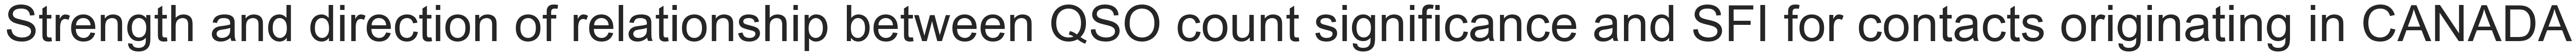

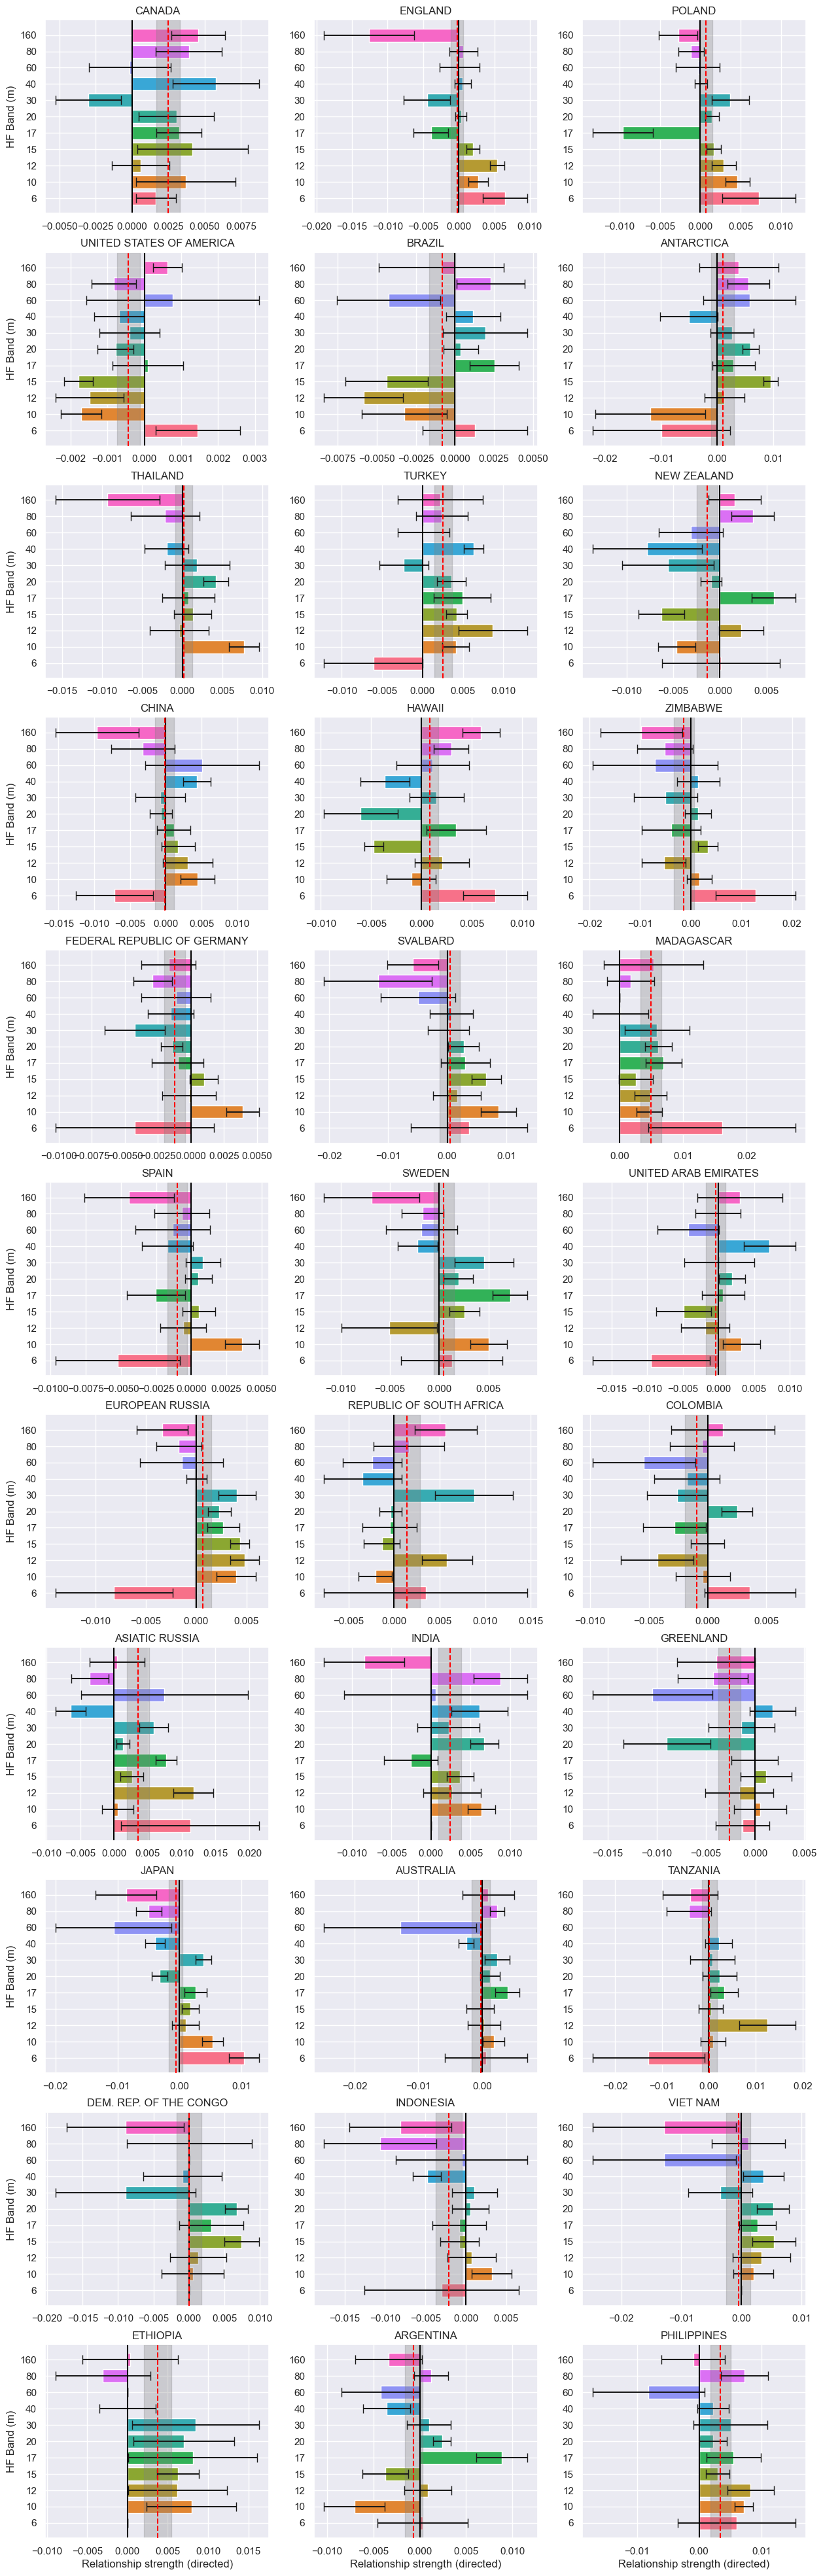

In [517]:
# Making barplots for comparing the strength and direction of the relationships between QSO count significance and SFI across various bands and destinations

palette = sns.color_palette("husl", 11)
source='CANADA'

nrows=11 

fig, ax = plt.subplots(figsize=(33,1))
ax.axis('off')
plt.suptitle(f'Strength and direction of relationship between QSO count significance and SFI for contacts originating in {source}',x=0.5, y=0.5, ha='center', va='center', fontsize=80)
plt.show()

fig, ax = plt.subplots(nrows,len(destinations)//nrows,figsize=(15,50))

# Fecthing all bands
first_dest=list(dataset.keys())[0]
sfi_ranges=list(dataset[first_dest]['All'].keys())
bands=list(dataset[first_dest]['All'][sfi_ranges[0]].keys())

for k in range(len(destinations)):
    
    dest=destinations[k]

    means=[coefs[dest][band][0][1] for band in bands]
    stds=[coefs[dest][band][1][1] for band in bands]
    sem = np.sqrt(np.sum(np.square(stds)) / len(means)) / np.sqrt(len(means) - 1)
    mean_reg = np.linspace(np.mean(means)-sem, np.mean(means)+sem, 100)
    
    ax[k%nrows,k//nrows].set_title(f'{dest}') 
    if k//nrows == 0:
        ax[k%nrows,k//nrows].set_ylabel('HF Band (m)')
    if k%nrows == nrows-1:
        ax[k%nrows,k//nrows].set_xlabel('Relationship strength (directed)')
        
    ax[k%nrows,k//nrows].barh(bands,means,xerr=stds,capsize=5,color=palette)
    ax[k%nrows,k//nrows].axvline(x=np.mean(means), linestyle='--', color='red',zorder=10)
    ax[k%nrows,k//nrows].axvline(x=0, linestyle='-', color='black')
    ax[k%nrows,k//nrows].axvspan(np.mean(means)-sem, np.mean(means)+sem, color='gray', alpha=0.3)
    ax[k%nrows,k//nrows].ticklabel_format(style='sci', axis='x')

plt.savefig('QSO_vs_SFI_strength.png')


#### Notes on the barplot zoo
- The vertical black line represents 0 strength (no relationship between QSO count significance and SFI).
- The size of each bar represents the strength of the relationship.
- Bars appearing on the left side of the black line describe negative relationships (negative correlation), whereas the ones appearing on the right of the black line suggest positive relationships (positive correlation)
- The dotted red line represents the average strength and direction of the relationship between QSO count significance and SFI across all bands. This measure should be taken with a grain of salt, considering that each band experiences different propagation conditions for a given SFI value. It makes a lot more sense to focus on relationships between QSO count significance and SFI for individual bands.
- The shaded region represents the standard error on the mean 
  
#### Insights and analysis  
- Within Canada, communication over HF bands appears to benefit from high SFI, since QSO count significance on all bands except for the 30m band tends to increase with increasing SFI. 
- The barplots of European regions all seem to share a common pattern: QSO count significance decreases with increasing SFI for longer wavelengths (160m, 80m, 60m), but increases with increasing SFI for shorter wavelengths. It is worthwhile to point out that the likelihood of a QSO on the 17m band with stations located in England and in Poland increases with decreasing SFI.
- In general, communication over HF bands with Asia, Oceania and nearby regions (like Madagascar, India, Ethiopia and the Philippines) seems to benefit from high SFI. However, when it comes to communicating with Japan and China, it is easy to see that QSO likelihood over shorter wavelength HF bands benefits from high SFI, while QSO likelihood over longer wavelength HF bands benefits from low SFI, much like it does in the case of European countries. A plausible explanation for this observation would be that amateurs in these countries (as well as in Canada) are priviledged to have the resources to build well-performing longer-wavelength stations and naturally switch to the longer wavelength bands in times of low SFI, expecting more favourable propagation conditions.
- The patterns for South American and African countries, as well as for Australia and New Zealand, are somewhat less apparent.


### Part 4: Building the two recommendation engines (destination and band)

In [21]:
# Recommendation engine for the most promising DESTINATIONS

def qso_count_sig_for_dest(month, band, hour, tolerance=0, dataset=qso_dataset): # Returns pandas dataframe whose indices are SFI ranges and whose columns are QSO count significances for each country
    
    if dataset==None:
        try:
            dataset=import_dataset('qso_data_dump.json')
        except:
            ValueError("QSO Dataset not found! Must either import one by running import_dataset('filename.json'); or scrape one using make_json and then import it.")
                         
    qso_dict={}

    # Getting SFI ranges
    first_dest=list(dataset.keys())[0]
    sfi_ranges=list(dataset[first_dest]['All'].keys())

    time_range=time_range_maker(hour,tolerance)

    for dest in dataset.keys():

        # Constructing QSO count significance
        y=[]
        for sfi_range in sfi_ranges: 
            qso_count=tree_sum([[dest],[month],[sfi_range],[str(band)],[str(hr) for hr in time_range]],dataset) # Number of contacts occuring on a given HF band in a specified time range in a given month between source and a given destination for a specific SFI range                                             
            qso_count_all_dest = tree_sum([[],[month],[sfi_range],[str(band)],[str(hr) for hr in time_range]],dataset) # Number of contacts occuring on a given HF band in a specified time range in a given month between source and ALL documented destinations for a specific SFI range
            if qso_count_all_dest!=0:
                y.append(qso_count/qso_count_all_dest)
            else:
                y.append(0)  
    
        qso_dict[dest]=y

    mydf = pd.DataFrame(qso_dict)
    mydf.index=sfi_ranges
    
    return mydf 

def best_dest(band=None, month=None, hour=None, tolerance=1, sfi=None, top=10, dataset=qso_dataset, consider_adjacent_ranges=True): # Recommmends the best candidates for QSOs

    if band==None:
        band=input("No band entered! Please enter one of the following bands: 6, 10, 12, 15, 17, 20, 30, 40, 60, 80, 160\n")
    if month==None:
        month=time.gmtime().tm_mon
    if hour==None:
        hour=time.gmtime().tm_hour
    if sfi==None:
        try:
            sfi=get_sfi()
        except:
            sfi=int(input("Failed to fetch current SFI! The SFI information on WM7D's website is probably getting updated. Please enter the SFI value manually:"))
        
    month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'}

    if type(month)==int:
        month=month_names[month]

    print('Making destination recommendations based on: \n')
    print('    SFI:',sfi)
    print('    Band:',str(band)+'m')
    print('    Month:',month)

    all_hours=set(range(24))
    time_range=time_range_maker(hour,tolerance)
    
    if set(time_range) != all_hours:
        print('    Time (hour):',hour,'(GMT)')
        print(f'    Tolerance: ±{tolerance}','hours, so filtering for hours:',time_range)
    else:
        print('    No time filter was applied since the implied time range captures all 24 hours.')

    print('')

    df=qso_count_sig_for_dest(month,band,hour,tolerance,dataset)

    print(f'Displaying the top {min(top,len(df.index))} QSO candidates:')

    print('')
    
    # Getting SFI ranges
    first_dest=list(dataset.keys())[0]
    sfi_ranges=list(dataset[first_dest]['All'].keys())

    for sfi_range in sfi_ranges:
        if sfi > eval(sfi_range)[0] and sfi <= eval(sfi_range)[1]:
            current_range=sfi_range
            break

    if consider_adjacent_ranges==False:
        
        return pd.DataFrame({'QSO Count Significance' : df.loc[current_range].sort_values(ascending=False)}).head(top)
        
    else:
        
        if sfi_ranges.index(current_range)-1>=0:
            range_l=sfi_ranges[sfi_ranges.index(current_range)-1]
        else:
            range_l=current_range

        if sfi_ranges.index(current_range)+1<=len(sfi_ranges)-1:
            range_u=sfi_ranges[sfi_ranges.index(current_range)+1]
        else:
            range_u=current_range

        qso_series=(df.loc[range_l]+df.loc[current_range]+df.loc[range_u])/3 # Averaging results using adjacent ranges should improve accuracy of predictions

        return pd.DataFrame({'QSO Count Significance' : qso_series.sort_values(ascending=False)}).head(top)


In [22]:
# Example
best_dest(band=20,tolerance=5) 

Making destination recommendations based on: 

    SFI: 124
    Band: 20m
    Month: April
    Time (hour): 15 (GMT)
    Tolerance: ±5 hours, so filtering for hours: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Displaying the top 10 QSO candidates:



,QSO Count Significance
UNITED STATES OF AMERICA,0.511406
POLAND,0.077507
FEDERAL REPUBLIC OF GERMANY,0.062990
CANADA,0.053633
ENGLAND,0.052867
SPAIN,0.040949
EUROPEAN RUSSIA,0.037895
JAPAN,0.037487
AUSTRALIA,0.036807
INDONESIA,0.026154


In [14]:
# Example
best_dest(sfi=280) 

No band entered! Please enter one of the following bands: 6, 10, 12, 15, 17, 20, 30, 40, 60, 80, 160
 20


Making destination recommendations based on: 

    SFI: 280
    Band: 20m
    Month: April
    Time (hour): 15 (GMT)
    Tolerance: ±1 hours, so filtering for hours: [14, 15, 16]

Displaying the top 10 QSO candidates:



,QSO Count Significance
UNITED STATES OF AMERICA,0.361111
JAPAN,0.118056
CANADA,0.104167
INDONESIA,0.041667
FEDERAL REPUBLIC OF GERMANY,0.020833
ASIATIC RUSSIA,0.020833
GREENLAND,0.000000
COLOMBIA,0.000000
TANZANIA,0.000000
AUSTRALIA,0.000000


In [23]:
# Recommendation engine for the most promising BANDS

def qso_count_sig_for_bands(month, hour, tolerance=0, dataset=qso_dataset): # Returns pandas dataframe whose indices are SFI ranges and whose columns are QSO count significances for each band
    
    if dataset==None:
        try:
            dataset=import_dataset('qso_data_dump.json')
        except:
            ValueError("QSO Dataset not found! Must either import one by running import_dataset('filename.json'); or scrape one using make_json and then import it.")
                         
    qso_dict={}

    # Getting SFI ranges and bands
    first_dest=list(dataset.keys())[0]
    sfi_ranges=list(dataset[first_dest]['All'].keys())
    bands=list(dataset[first_dest]['All'][sfi_ranges[0]].keys())

    time_range=time_range_maker(hour,tolerance)

    for band in bands:

        # Constructing QSO count significance (analogous version): the ratio of QSO counts occuring on a given band to QSO counts occuring on all the documented bands.
        y=[]
        for sfi_range in sfi_ranges:  
                                                                      
            qso_count = tree_sum([[],[month],[sfi_range],[band],[str(hr) for hr in time_range]],dataset) # Number of contacts occuring in a specified time range on a given HF band originating at a given source in a given month for a specific SFI range 
            qso_count_all_bands = tree_sum([[],[month],[sfi_range],[],[str(hr) for hr in time_range]],dataset) # Number of contacts occuring in a specified time range on all HF bands originating at a given source in a given month for a specific SFI range 
            
            if qso_count_all_bands!=0:
                y.append(qso_count/qso_count_all_bands)
            else:
                y.append(0)  
    
        qso_dict[band]=y

    mydf = pd.DataFrame(qso_dict)
    mydf.index=sfi_ranges
    
    return mydf 

def best_bands(month=None, hour=None, tolerance=1, sfi=None, dataset=qso_dataset, consider_adjacent_ranges=True): # Recommmends the best bands

    if month==None:
        month=time.gmtime().tm_mon
    if hour==None:
        hour=time.gmtime().tm_hour
    if sfi==None:
        try:
            sfi=get_sfi()
        except:
            sfi=int(input('Failed to fetch current SFI! Please enter the SFI value:'))
        
    month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'}

    if type(month)==int:
        month=month_names[month]

    print('Making band recommendations based on: \n')
    print('    SFI:',sfi)
    print('    Month:',month)

    all_hours=set(range(24))
    time_range=time_range_maker(hour,tolerance)
    
    if set(time_range) != all_hours:
        print('    Time (hour):',hour,'(GMT)')
        print(f'    Tolerance: ±{tolerance}','hours, so filtering for hours:',time_range)
    else:
        print('    No time filter was applied since the the implied time range captures all 24 hours.')

    print('')

    df=qso_count_sig_for_bands(month,hour,tolerance,dataset)
    
    # Getting SFI ranges
    first_dest=list(dataset.keys())[0]
    sfi_ranges=list(dataset[first_dest]['All'].keys())

    for sfi_range in sfi_ranges:
        if sfi > eval(sfi_range)[0] and sfi <= eval(sfi_range)[1]:
            current_range=sfi_range
            break

    if consider_adjacent_ranges==False:
        
        return pd.DataFrame({'QSO Count Significance' : df.loc[current_range].sort_values(ascending=False)})
        
    else:
        
        if sfi_ranges.index(current_range)-1>=0:
            range_l=sfi_ranges[sfi_ranges.index(current_range)-1]
        else:
            range_l=current_range

        if sfi_ranges.index(current_range)+1<=len(sfi_ranges)-1:
            range_u=sfi_ranges[sfi_ranges.index(current_range)+1]
        else:
            range_u=current_range

        qso_series=(df.loc[range_l]+df.loc[current_range]+df.loc[range_u])/3 # Averaging results using adjacent ranges should improve accuracy of predictions

        return pd.DataFrame({'QSO Count Significance' : qso_series.sort_values(ascending=False)})
        

In [24]:
# Example
best_bands(sfi=300)

Making band recommendations based on: 

    SFI: 300
    Month: April
    Time (hour): 15 (GMT)
    Tolerance: ±1 hours, so filtering for hours: [14, 15, 16]



,QSO Count Significance
15,0.780303
10,0.159091
20,0.045455
12,0.015152
6,0.000000
17,0.000000
30,0.000000
40,0.000000
60,0.000000
80,0.000000


In [17]:
# Example
best_bands(sfi=280)

Making band recommendations based on: 

    SFI: 280
    Month: April
    Time (hour): 15 (GMT)
    Tolerance: ±1 hours, so filtering for hours: [14, 15, 16]



,QSO Count Significance
15,0.650673
10,0.223906
20,0.094837
12,0.018238
40,0.012346
6,0.000000
17,0.000000
30,0.000000
60,0.000000
80,0.000000
